## Playing around with `torch_dreams`

This simple library was heavily inspired from: [Feature Visualization: How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/)

`torch_dreams` aims to be something like [tensorflow/lucid](https://github.com/tensorflow/lucid) but in PyTorch in order to facilitate research in neural network interpretability

**Note**: This is by no means a PyTorch equivalent of lucid. But rather it is a bunch of useful tools which have similar intent to that of lucid.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from torch_dreams.dreamer import dreamer
from torch_dreams.models.googlenet import GoogLeNet


In [2]:
model = GoogLeNet()
l = list(model.children())
good_layers = model.layer_names
good_layers

['inception3b', 'inception4c', 'inception4d', 'inception4e']

### Deep-dreams w.r.t conv layers 
Simple and straight, here we try to maximize the activations of the a conv layer as a whole. 

In [188]:
layer = model.inception4e.branch1.conv
layers_to_use = [layer]
layers_to_use

[Conv2d(528, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)]

In [189]:
dreamy_boi = dreamer(model)

dreamer init on:  cuda


In [190]:
out_single_conv = dreamy_boi.deep_dream(
    image_path = "images/sample.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 12,
    iterations =40,
    lr = 0.9,
    custom_func =  None
)

100%|██████████| 13/13 [00:16<00:00,  1.30s/it]


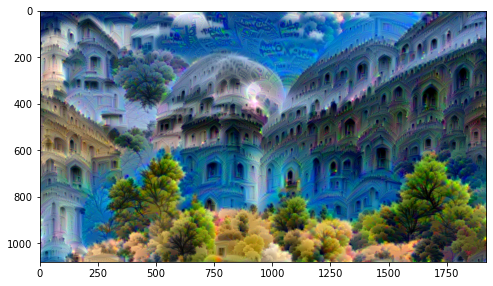

In [191]:
plt.rcParams['figure.figsize'] = 8, 8
plt.imshow(out_single_conv)
plt.show()

### Deep-dreams w.r.t individual channels of conv layers 

This time, we aim to optimize the 0th channel of the conv layer. Notice how `my_custom_func` is tweaked to extract the activations of the 0th channel with `loss = layer_outputs[0][0].norm()`

In [282]:
layer = model.inception4e.branch1.conv
layer2 = model.inception3b.branch1.conv
layers_to_use = [layer, layer2]
layers_to_use

[Conv2d(528, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
 Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)]

In [275]:
def my_custom_func(layer_outputs):
    """
    this custom func would get applied to the list of layer outputs
    the layers whose outputs are given here are the ones you asked for in the layers arg
    """
#     activations = np.array([i.norm() for i in layer_outputs[0]])
#     print(np.argmax(activations))
#     plt.plot(activations)
#     plt.show()
    loss = layer_outputs[0][0].norm()  ## first channel from first layer 
    return loss

out_single_channel = dreamy_boi.deep_dream(
    image_path = "images/sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 12,
    iterations =23,
    lr = 1.4,
    custom_func =  my_custom_func,
)

100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


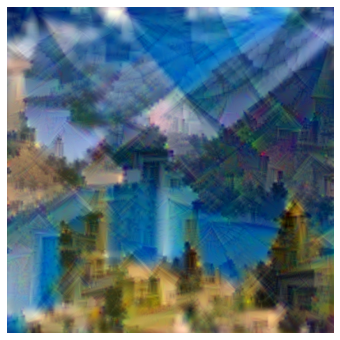

True

In [289]:
plt.rcParams['figure.figsize'] = 6,6
plt.axis("off")
plt.imshow(out_single_channel)
plt.show()
cv2.imwrite("images/raw_output/googlenet.inception4e.branch1.conv.channel_0.jpg", cv2.cvtColor(out_single_channel*255, cv2.COLOR_BGR2RGB))

In [290]:
def my_custom_func(layer_outputs):

    loss = layer_outputs[1][12].norm()  ## 15 gives feathers 
    return loss

out_single_channel_2 = dreamy_boi.deep_dream(
    image_path = "images/sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.4,
    num_octaves = 10,
    iterations =43,
    lr = 1.4,
    custom_func =  my_custom_func
)

100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


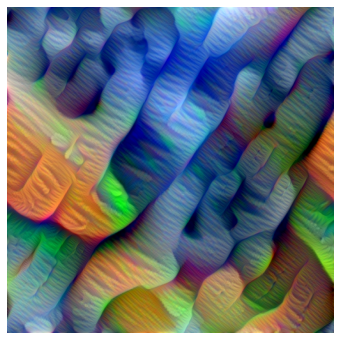

True

In [291]:
plt.rcParams['figure.figsize'] = 6,6
plt.axis("off")
plt.imshow(out_single_channel_2)
plt.show()

cv2.imwrite("images/raw_output/googlenet.inception3b.branch1.conv.channel_12.jpg", cv2.cvtColor(out_single_channel_2*255, cv2.COLOR_BGR2RGB))

In [297]:
def my_custom_func(layer_outputs):
    
    loss = layer_outputs[1][12].norm()  + layer_outputs[0][0].norm()
#     print(loss)
    return loss

out_channel_blend = dreamy_boi.deep_dream(
    image_path = "images/sample_small.jpg",
    layers = layers_to_use,
    octave_scale = 1.2,
    num_octaves = 14,
    iterations =23,
    lr = 0.9,
    custom_func =  my_custom_func
)

100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


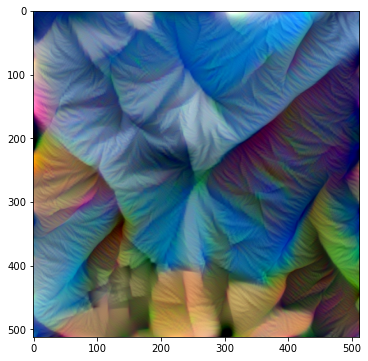

True

In [299]:
plt.rcParams['figure.figsize'] = 6,6
plt.imshow(out_channel_blend)
plt.show()
cv2.imwrite("images/raw_output/blend_inception3b.branch1.conv.channel_12_and_inception4e.branch1.conv.channel_0.jpg",  cv2.cvtColor(out_channel_blend*255, cv2.COLOR_BGR2RGB))